# "2021(제2회) NH투자증권 빅데이터 경진대회"

안녕하세요! 앙몬드 팀입니다. 주식 보유기간 예측이라는  주제가 흥미로워 더욱 즐겁게 분석에 참여할 수 있었습니다. 

저희는 1) 과거 이력 칼럼에서 보유일자 찾기 2) 후처리로 예측값의 상한선과 하한성 정하기 를 통해 주로 점수를 올릴 수 있었습니다.

부족한 실력으로 코드를 작성하였습니다. 너그럽게 봐주시면 감사하겠습니다.

### 패키지 설치 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from numpy import int64
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import FinanceDataReader as fdr

In [2]:
cus=pd.read_csv('./cus_info.csv')  ## 고객, 주거래계좌 정보
iem=pd.read_csv('./iem_info_20210902.csv')  ## 종목 정보
sample=pd.read_csv('./sample_submission.csv')
hist=pd.read_csv('./stk_bnc_hist.csv') ## 잔고 정보
test=pd.read_csv('./stk_hld_test.csv') ## 20년 이전~21년 
train=pd.read_csv('./stk_hld_train.csv') ## 16년~20년

### 고객 데이터 분석

#### 고객 데이터의 분포 확인 

4    1567
3    1524
6    1415
2    1378
5    1369
7    1098
8     787
1     481
9     381
Name: cus_age_stn_cd, dtype: int64


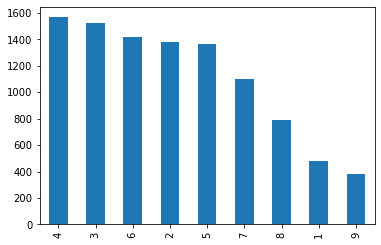

In [3]:
#연령구간의 분포 확인
print(cus['cus_age_stn_cd'].value_counts())
cus['cus_age_stn_cd'].value_counts().plot.bar()

- 01: 20세~25세미만
- 02: 25세~30세미만
- `03: 30세~35세미만` 2등
- `04: 35세~40세미만` 1등
- 05: 40세~45세미만
- `06: 45세~50세미만` 3등
- 07: 50세~55세미만
- 08: 55세~60세미만
- 09: 60세~65세미만

99    3687
4     1858
3     1669
2     1467
5      935
1      210
0      171
9        3
Name: ivs_icn_cd, dtype: int64


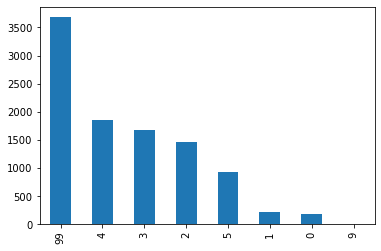

In [4]:
#투자성향 필드 값의 분포 확인
print(cus['ivs_icn_cd'].value_counts())
cus['ivs_icn_cd'].value_counts().plot.bar()

- 01: 안정형
- 02: 안정추구형
- `03: 위험중립형` 3등
- `04: 적극투자형` 2등
- 05: 공격투자형
- 09: 전문투자가형
- 00: 정보제공미동의
- `99: 미정의` 1등

`투자 성향이 주식 보유 기간과 연관되어 있을 것으로 예상하여 '미정의'를 가공하는 것이 중요하다고 생각하였습니다.`

1    3572
2    2740
4    1222
3    1147
5     984
6     335
Name: cus_aet_stn_cd, dtype: int64


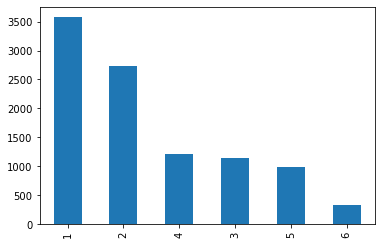

In [5]:
#고객자산구간 필드 값의 분포 확인
print(cus['cus_aet_stn_cd'].value_counts())
cus['cus_aet_stn_cd'].value_counts().plot.bar()

- `01: 0원이상-1천만원미만` 1등
- `02: 1천만원이상-3천만원미만` 2등
- 03: 3천만원이상-5천만원미만
- `04: 5천만원이상-1억원미만` 3등
- 05: 1억원이상-3억원미만
- 06: 3억원이상

In [6]:
#주거래상품군 필드 값의 분포 확인
print(cus['mrz_pdt_tp_sgm_cd'].value_counts())

2     9659
3      261
1       34
15      10
10       9
8        8
5        7
9        5
6        3
11       3
12       1
Name: mrz_pdt_tp_sgm_cd, dtype: int64


- 01: Only CMA
- `02: 국내주식` 압도적인 1위
- `03: 해외주식` 
- 04: 선물옵션
- 05: 금속
- 06: 국내채권
- 07: 해외채권
- 08: 펀드
- 09: ELS/DLS
- 10: 신탁_퇴직연금
- 11: RP
- 12: 발행어음
- 14: WRAP
- 15: 신용대출
- 99: 미정의
    
대체로 국내주식에 몰려 있어 크게 의미가 없는 것으로 판단하였고, 분석 과정에서 제거하였습니다.

3    4271
2    3315
4     992
1     962
5     312
6     148
Name: tot_ivs_te_sgm_cd, dtype: int64


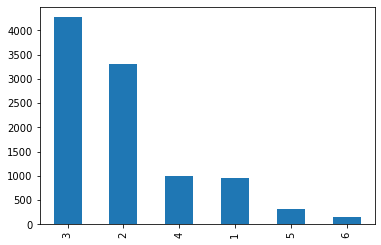

In [7]:
#총투자기간 필드 값의 분포 확인
print(cus['tot_ivs_te_sgm_cd'].value_counts())
cus['tot_ivs_te_sgm_cd'].value_counts().plot.bar()

- 01: 6개월 미만
-`  02: 6개월-1년 미만` 2등
- ` 03: 1년-3년 미만`  1등
- ` 04: 3년-5년 미만`  3등
- 05: 5년-10년 미만
- 06: 10년 이상

10    2107
16    2024
9     1320
13     867
5      831
8      550
14     496
6      488
12     325
7      324
2      322
11      83
3       79
1       75
15      63
4       46
Name: mrz_btp_dit_cd, dtype: int64


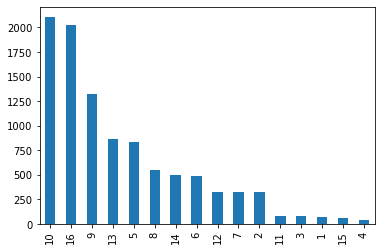

In [8]:
#주거래업종구분 필드 값의 분포 확인
print(cus['mrz_btp_dit_cd'].value_counts())
cus['mrz_btp_dit_cd'].value_counts().plot.bar()

- 01: 건설업
- 02: 금융업
- 03: 기계
- 04: 방송/통신
- 05: 서비스/오락/문화
- 06: 운송/운수
- 07: 유통
- 08: 의료/의약
- ` 09: 전기/전자`  3등
- ` 10: 제조` 1등
- 11: 철강
- 12: 화학
- ` 13: IT` 4등
- 14: 기타
- 15: 혼합
- ` 16: 비매매"` 2등
    
비매매의 비율이 높아, 데이터 분석 시 유의할 점으로 생각하였습니다.

In [9]:
cus.corr().round(2) 

,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd
sex_dit_cd,1.00,0.03,0.12,-0.09,-0.01,0.15,0.06,-0.07,0.01
cus_age_stn_cd,0.03,1.00,0.13,0.30,-0.01,0.87,-0.14,0.24,0.00
ivs_icn_cd,0.12,0.13,1.00,-0.13,-0.07,0.13,0.09,-0.10,0.06
cus_aet_stn_cd,-0.09,0.30,-0.13,1.00,0.04,0.26,-0.36,0.31,-0.10
mrz_pdt_tp_sgm_cd,-0.01,-0.01,-0.07,0.04,1.00,-0.01,-0.02,0.05,0.00
lsg_sgm_cd,0.15,0.87,0.13,0.26,-0.01,1.00,-0.12,0.19,0.01
tco_cus_grd_cd,0.06,-0.14,0.09,-0.36,-0.02,-0.12,1.00,-0.23,0.02
tot_ivs_te_sgm_cd,-0.07,0.24,-0.10,0.31,0.05,0.19,-0.23,1.00,0.06
mrz_btp_dit_cd,0.01,0.00,0.06,-0.10,0.00,0.01,0.02,0.06,1.00


(life stage,나이) (서비스등급,자산구간) (총투자기간, 자산구간) 만 0.3 이상의 상관관계를 가지고 있는 것으로 나왔습니다.

## 주식 데이터 분석 및 전처리

In [3]:
iem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079 entries, 0 to 3078
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   iem_cd                3079 non-null   object
 1   iem_krl_nm            3079 non-null   object
 2   btp_cfc_cd            3079 non-null   int64 
 3   mkt_pr_tal_scl_tp_cd  3079 non-null   int64 
 4   stk_dit_cd            3079 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 120.4+ KB


iem_krl_nm은 주식 명으로 주식 코드(iem_cd)와 같은 정보이므로 제거하였습니다.

14    835
10    666
13    455
2     211
5     203
7     150
12    121
6      95
9      82
11     78
1      61
8      57
3      43
4      22
Name: btp_cfc_cd, dtype: int64


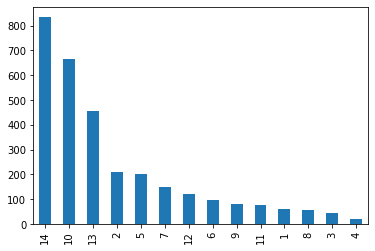

In [10]:
#종목 업종 필드 값의 분포 확인
print(iem['btp_cfc_cd'].value_counts())
iem['btp_cfc_cd'].value_counts().plot.bar()

- 01: 건설업
- 02: 금융업
- 03: 기계
- 04: 방송/통신
- 05: 서비스/오락/문화
- 06: 운송/운수
- 07: 유통
- 08: 의료/의약
- 09: 전기/전자  
- 10: 제조
- 11: 철강
- 12: 화학
- 13: IT
- 14: 기타
    
고객 데이터의 주거래 업종 칼럼과 비슷한 내용입니다.

3     1577
99     789
2      512
1      201
Name: mkt_pr_tal_scl_tp_cd, dtype: int64


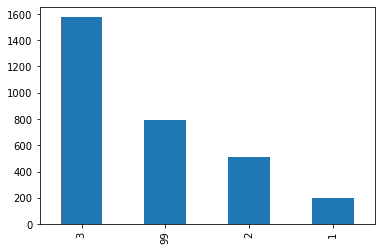

In [11]:
# 시가 총액 규모 필드 값의 분포 확인
print(iem['mkt_pr_tal_scl_tp_cd'].value_counts())
iem['mkt_pr_tal_scl_tp_cd'].value_counts().plot.bar()

- 01: 대형주
- 02: 중형주
- 03: 소형주
- 04: 기타

시장 구분을 위해 기존의 칼럼이 아닌 finance data reader의 주식 리스트를 이용하여 시장 구분을 하겠습니다. 

In [12]:
# 주식 리스트 데이터 셋을 만들겠습니다.
df_krx=fdr.StockListing('KRX')
df_kosdaq=fdr.StockListing('KOSDAQ')
df_kospi=fdr.StockListing('KOSPI')
df_konex=fdr.StockListing('KONEX')
result=pd.concat([df_krx,df_kosdaq,df_kospi,df_konex],ignore_index=True)
result=result.drop_duplicates(['Symbol'],keep='first')
df_stock=result[['Symbol','Market']]

In [13]:
## 주식 코드가 일치하도록 숫자만 가져오겠습니다.
iem['iem_cd']=iem['iem_cd'].str.slice(start=1, stop=7)  
iem = pd.merge(iem, df_stock, how = "left",left_on='iem_cd',right_on='Symbol')

In [14]:
pd.crosstab(iem.Market, iem.stk_dit_cd)  ## 기존 시장 구분 칼럼(stk_dit_cd)의 기타 항목을 잘 대체하였습니다.

stk_dit_cd,1,2,99
Market,,,
KOSDAQ,0,150,1322
KOSPI,200,0,1075


In [15]:
iem.loc[iem['Market']=='KOSDAQ', 'Market'] = 1   ## 코스닥에 더 가중치를 두겠습니다.
iem.loc[iem['Market']=='KOSPI', 'Market'] = 0
iem=iem.fillna(0)

In [16]:
iem=iem[['iem_cd','btp_cfc_cd','mkt_pr_tal_scl_tp_cd','Market']]

## 과거 보유 데이터 분석 및 전처리

우선 id, 주식 별로 보유 기간을 구해봅니다. 

In [17]:
hist.head()

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0


In [18]:
hist[hist['act_id']=='fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6bc012f43564f626533'].head(20)

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr
1555409,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201204,A204320,1.0,54600.0,1000.0
1555410,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201214,A204320,3.0,157200.0,1000.0
1555411,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201217,A204320,4.0,216800.0,1000.0
1555412,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201223,A204320,0.0,0.0,1000.0
1555413,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20200910,A217330,16.0,461600.0,500.0
1555414,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201013,A251270,1.0,153500.0,100.0
1555415,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201208,A251270,0.0,0.0,100.0
1555416,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20200130,A253450,1.0,84700.0,500.0
1555417,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20200805,A253450,0.0,0.0,500.0
1555418,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201217,A264450,2.0,52900.0,500.0


한 아이디의 거래 내역을 출력해보면 잔고수량이 0이 될 때가 있는데요. 

잔고수량이 0인 날짜 중 제일 늦은 날짜를 전체 매도 날짜로 잡고, 매수일자 중 가장 빠른 날을 매수일로 하겠습니다.

In [20]:
## id, 주식 별 그룹 중 가장 빠른 날짜
df=pd.DataFrame(hist.groupby(['act_id','iem_cd'])['bse_dt'].min()).reset_index()
df.rename(columns={'bse_dt':'byn_dt'},inplace=True)

## 잔고수량이 0인 데이터
hist0=hist[(hist['bnc_qty'])==0]  
df2=pd.DataFrame(hist0.groupby(['act_id','iem_cd'])['bse_dt'].max()).reset_index()

## 합치기
df3=pd.merge(df,df2,how='inner',on=["act_id","iem_cd"])
df3

,act_id,iem_cd,byn_dt,bse_dt
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A002270,20190321,20200818
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,20190327,20190423
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,20190320,20190321
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,20190326,20190712
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A036000,20190611,20191220
...,...,...,...,...
433500,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A253450,20200130,20200805
433501,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A264450,20201217,20201230
433502,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A267320,20201007,20201214
433503,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A293490,20200914,20201214


이제는 주식 보유일을 계산하도록 하겠습니다.

In [21]:
df3['byn_dt'] = (df3['byn_dt']).astype(str) 
df3['bse_dt'] = (df3['bse_dt']).astype(str) 

df3['byn_dt'] = pd.to_datetime(df3['byn_dt'], errors='coerce')
df3['bse_dt'] = pd.to_datetime(df3['bse_dt'], errors='coerce')
A = [d.date() for d in df3['byn_dt']]
B = [d.date() for d in df3['bse_dt']]
df3['DIFF'] = np.busday_count(A, B)

In [22]:
## 편한 merge를 위해 이름을 다시 바꾸겠습니다. hist의 날짜도 datetime 형식으로 바꾸었습니다.
df3.rename(columns={'byn_dt':'bse_dt','bse_dt':'bse_dt2'},inplace=True)
hist['bse_dt'] = (hist['bse_dt']).astype(str) 
hist['bse_dt'] = pd.to_datetime(hist['bse_dt'], errors='coerce')

In [23]:
new_hist=pd.merge(df3,hist,how='inner',on=["act_id","iem_cd","bse_dt"])
new_hist=new_hist[['act_id','iem_cd','bse_dt','DIFF','bnc_qty','tot_aet_amt']]  
new_hist["stk_p"] = new_hist["tot_aet_amt"] / new_hist["bnc_qty"]
new_hist = new_hist.fillna(0)

In [24]:
new_hist

,act_id,iem_cd,bse_dt,DIFF,bnc_qty,tot_aet_amt,stk_p
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A002270,2019-03-21,368,1.0,667000.0,667000.0
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,2019-03-27,19,10.0,152500.0,15250.0
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,2019-03-20,1,10.0,440500.0,44050.0
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,2019-03-26,78,5.0,130250.0,26050.0
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A036000,2019-06-11,138,20.0,99300.0,4965.0
...,...,...,...,...,...,...,...
433500,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A253450,2020-01-30,134,1.0,84700.0,84700.0
433501,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A264450,2020-12-17,9,2.0,52900.0,26450.0
433502,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A267320,2020-10-07,48,15.0,81600.0,5440.0
433503,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A293490,2020-09-14,65,2.0,147600.0,73800.0


In [25]:
new_hist['iem_cd']=new_hist['iem_cd'].str.slice(start=1, stop=7)
hist_b=new_hist[['act_id','iem_cd','DIFF']]
new=pd.merge(hist,hist_b,how='left',on=['act_id','iem_cd'])
new[['bse_dt']] = new[['bse_dt']].applymap(str).applymap(lambda s: "{}-{}-{}".format(s[0:4],s[4:6],s[6:] ))

여기서 추후에 보정하고자 하는 것은 주말을 제외한 공휴일을 추가하는 것입니다.

참고로 전량 매도를 하지 않은 주식은  2020-12-31까지의 보유기간을 넣었습니다.


In [249]:
for i in range(0,len(new)):
    if pd.isnull(new['DIFF'][i]):
        new['DIFF'][i] = np.busday_count(new['bse_dt'][i], '2020-12-31')


<ipython-input-249-c56ba526e340>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['DIFF'][i] = np.busday_count(new['bse_dt'][i], '2020-12-31')


In [252]:
new.to_csv('new.csv',index=False)

In [257]:
new

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,DIFF
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2020-08-20,008770,40.0,2828000.0,5000.0,95.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2020-06-23,008770,20.0,1390000.0,5000.0,137.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2016-01-04,005940,311.0,2982490.0,5000.0,1303.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2020-08-14,005930,40.0,2320000.0,100.0,99.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2020-06-23,005930,20.0,1028000.0,100.0,137.0
...,...,...,...,...,...,...,...
2573834,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2020-08-06,035720,1.0,364000.0,500.0,13.0
2573835,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2020-08-13,035720,0.0,0.0,500.0,13.0
2573836,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2020-08-19,035720,1.0,376500.0,500.0,13.0
2573837,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2020-08-25,035720,0.0,0.0,500.0,13.0


## Train, Test 데이터 준비

In [70]:
test=pd.read_csv('./stk_hld_test.csv') ## 20년 이전~21년 
train=pd.read_csv('./stk_hld_train.csv') ## 16년~20년
new=pd.read_csv('./new.csv')  ## hist

In [71]:
cus_2=cus[['act_id','sex_dit_cd','cus_aet_stn_cd','lsg_sgm_cd','tco_cus_grd_cd','tot_ivs_te_sgm_cd','mrz_btp_dit_cd','ivs_icn_cd']]

In [72]:
train["hist_d"] = train["hold_d"]*0.55
train.hist_d = np.trunc(train["hist_d"])

train['iem_cd']=train['iem_cd'].str.slice(start=1, stop=7)  
test['iem_cd']=test['iem_cd'].str.slice(start=1, stop=7)

In [73]:
new['bse_dt']=new['bse_dt'].str.replace('-','').apply(int)

In [74]:
new["stk_p"] = new["tot_aet_amt"] / new["bnc_qty"]
new = new.fillna(0)

In [75]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.

train_data = pd.merge(train, cus_2, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus_2, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.

train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

In [76]:
train_data = pd.merge(train_data, new, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, new, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)


### 추가적으로 전처리를 하겠습니다.

In [77]:
train_data['byn_dt'] = (train_data['byn_dt']).astype(str) 
train_data['byn_dt']=pd.to_datetime(train_data['byn_dt'], errors='coerce')

train_data['week'] = train_data['byn_dt'].dt.weekofyear
train_data['year'] = train_data['byn_dt'].dt.year
train_data['month'] = train_data['byn_dt'].dt.month

test_data['byn_dt'] = (test_data['byn_dt']).astype(str) 
test_data['byn_dt']=pd.to_datetime(test_data['byn_dt'], errors='coerce')

test_data['week'] = test_data['byn_dt'].dt.weekofyear
test_data['year'] = test_data['byn_dt'].dt.year
test_data['month'] = test_data['byn_dt'].dt.month

In [79]:
train_data=train_data.drop(['byn_dt','bse_dt','act_id','iem_cd',"tot_aet_amt","bnc_qty",'stk_par_pr'], axis = 1)
test_data=test_data.drop(['byn_dt','bse_dt','submit_id','hold_d','act_id','iem_cd',"tot_aet_amt","bnc_qty",'stk_par_pr'], axis = 1)

In [81]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70596 entries, 0 to 70595
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hist_d                70596 non-null  int64  
 1   sex_dit_cd            70596 non-null  int64  
 2   cus_aet_stn_cd        70596 non-null  int64  
 3   lsg_sgm_cd            70596 non-null  int64  
 4   tco_cus_grd_cd        70596 non-null  int64  
 5   tot_ivs_te_sgm_cd     70596 non-null  int64  
 6   mrz_btp_dit_cd        70596 non-null  int64  
 7   ivs_icn_cd            70596 non-null  int64  
 8   btp_cfc_cd            70596 non-null  int64  
 9   mkt_pr_tal_scl_tp_cd  70596 non-null  int64  
 10  Market                70596 non-null  int64  
 11  DIFF                  70596 non-null  float64
 12  stk_p                 70596 non-null  float64
 13  week                  70596 non-null  int64  
 14  year                  70596 non-null  int64  
 15  month              

In [80]:
print(train_data.shape)
print(test_data.shape)

(681472, 16)
(70596, 16)


## LGBM + StratifiedKFold

모델은 lgbm과 stratified k fold를 사용하였습니다. 

In [82]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold

n_splits = 10
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(test_data))
X=train_data
y=train_label

skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))
             
    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]

    X_val = X.iloc[valid_idx, :]
    y_val = y[valid_idx]

    lgbm = LGBMRegressor(n_estimators = 7000, objective = 'mse', learning_rate= 0.01, num_leaves=31)
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds=100,verbose = 100)
    y_pred += lgbm.predict(test_data) / n_splits

C:\Users\Jeong Eun\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 19.2392	valid_0's l2: 370.145
[200]	valid_0's rmse: 7.05555	valid_0's l2: 49.7808
[300]	valid_0's rmse: 2.61607	valid_0's l2: 6.84384
[400]	valid_0's rmse: 1.05056	valid_0's l2: 1.10367
[500]	valid_0's rmse: 0.575145	valid_0's l2: 0.330792
[600]	valid_0's rmse: 0.480658	valid_0's l2: 0.231032
[700]	valid_0's rmse: 0.46425	valid_0's l2: 0.215528
[800]	valid_0's rmse: 0.464053	valid_0's l2: 0.215345
Early stopping, best iteration is:
[716]	valid_0's rmse: 0.463069	valid_0's l2: 0.214433
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 19.2334	valid_0's l2: 369.923
[200]	valid_0's rmse: 7.07175	valid_0's l2: 50.0096
[300]	valid_0's rmse: 2.68169	valid_0's l2: 7.19143
[400]	valid_0's rmse: 1.2283	valid_0's l2: 1.50872
[500]	valid_0's rmse: 0.87948	valid_0's l2: 0.773485
[600]	valid_0's rmse: 0.829685	valid_0's l2: 0.688377
Early stopping, best iteration is:
[599]	valid_0's

[4700]	valid_0's rmse: 1.13971	valid_0's l2: 1.29893
[4800]	valid_0's rmse: 1.1348	valid_0's l2: 1.28777
[4900]	valid_0's rmse: 1.13158	valid_0's l2: 1.28048
[5000]	valid_0's rmse: 1.12947	valid_0's l2: 1.27569
[5100]	valid_0's rmse: 1.12563	valid_0's l2: 1.26705
[5200]	valid_0's rmse: 1.11974	valid_0's l2: 1.25382
[5300]	valid_0's rmse: 1.11876	valid_0's l2: 1.25163
[5400]	valid_0's rmse: 1.11591	valid_0's l2: 1.24526
[5500]	valid_0's rmse: 1.11707	valid_0's l2: 1.24783
Early stopping, best iteration is:
[5460]	valid_0's rmse: 1.11438	valid_0's l2: 1.24184
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 19.3996	valid_0's l2: 376.344
[200]	valid_0's rmse: 7.20141	valid_0's l2: 51.8603
[300]	valid_0's rmse: 2.80696	valid_0's l2: 7.879
[400]	valid_0's rmse: 1.35064	valid_0's l2: 1.82424
[500]	valid_0's rmse: 0.969111	valid_0's l2: 0.939177
[600]	valid_0's rmse: 0.874473	valid_0's l2: 0.764703
[700]	valid_0's rmse: 0.846242	valid_0's l2: 0.716125
[800]	

In [83]:
y_pred

array([279.66883817, 607.99635153, 253.39550842, ..., 877.02578878,
        19.16147287,   8.46677756])

### 후 처리

 hold_d(전체 보유기간) - hist_d(2020.12.31까지의 보유기간) 은 146일 이내입니다.
 
 따라서 예측값인 hold_d는 hist_d+146을 넘지 않도록 해야 합니다.
 
 또한 hist_d가 hold_d보다 작을 수는 없습니다.

 따라서 hold_d의 상한선과 하한선을 지정하는 방법으로 후처리를 진행하였습니다.

In [84]:
test=pd.read_csv('stk_hld_test.csv') 
test["hold_d"] = np.round(y_pred)
test["hist_new"]=test["hist_d"]+146
df=test[['hist_new','hold_d','hist_d']]
mins=test[['hist_new','hold_d']].min(axis=1)  ## 상한선 지정
df["upper"]=mins
maxs=df[['hist_d','upper']].max(axis=1)    ## 하한선 지정
df["ans"]=maxs


sample["hold_d"]=maxs
sample['hold_d'].describe()

<ipython-input-84-a969872bcb4c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["upper"]=mins
<ipython-input-84-a969872bcb4c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ans"]=maxs


count    70596.000000
mean       172.292821
std        203.574614
min          2.000000
25%         25.000000
50%        102.000000
75%        240.000000
max       1227.000000
Name: hold_d, dtype: float64

### 최종 결과물을 제출합니다.

In [85]:
sample.to_csv("my2.csv", index = False)